# Stock price prediction using RNNs

## Setup and imports

In [61]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
from pathlib import Path
from typing import Callable

import numpy as np
import numpy.typing as npt
import pandas as pd

from load_google_data import load_google_stock_data, unnormalise
from activation_functions import elu, leaky_relu, relu, sigmoid, tanh
from rnn import RNN

## Loading data

In [70]:
# Paths to training and testing data
train_filepath = Path(
    "/mnt/c/Users/chris/OneDrive/University/2024/Deep Learning Fundamentals/assignment3/Google_Stock_Price_Train.csv"
)
test_filepath = Path(
    "/mnt/c/Users/chris/OneDrive/University/2024/Deep Learning Fundamentals/assignment3/Google_Stock_Price_Test.csv"
)


train_data, normalisation_params = load_google_stock_data(train_filepath)
test_data, _ = load_google_stock_data(test_filepath)

            Date    Open    High     Low   Close    Volume
0       1/3/2012  325.25  332.83  324.97  663.59   7380500
1       1/4/2012  331.27  333.87  329.08  666.45   5749400
2       1/5/2012  329.83  330.75  326.89  657.21   6590300
3       1/6/2012  328.34  328.77  323.68  648.24   5405900
4       1/9/2012  322.04  322.29  309.46  620.76  11688800
...          ...     ...     ...     ...     ...       ...
1253  12/23/2016  790.90  792.74  787.28  789.91    623400
1254  12/27/2016  790.68  797.86  787.66  791.55    789100
1255  12/28/2016  793.70  794.23  783.20  785.05   1153800
1256  12/29/2016  783.33  785.93  778.92  782.79    744300
1257  12/30/2016  782.75  782.78  770.41  771.82   1770000

[1149 rows x 6 columns]
         Date    Open    High     Low   Close   Volume
0    1/3/2017  778.81  789.63  775.80  786.14  1657300
1    1/4/2017  788.36  791.34  783.16  786.90  1073000
2    1/5/2017  786.08  794.48  785.02  794.02  1335200
3    1/6/2017  795.26  807.90  792.20  806.15  

## Creating sequences of data

In [64]:
# Create sequences for training (sequence_length is the number of past days to predict the next day)
def create_sequences(
    data: npt.NDArray[np.float32], sequence_length: int
) -> list[tuple[npt.NDArray[np.float32], float]]:
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i : i + sequence_length, :]
        target = float(
            data[i + sequence_length, 3]
        )  # 'Close' value on final day of sequence as target
        sequences.append((seq, target))
    return sequences

## Training function

In [65]:
# Training Function
def train_rnn(
    rnn: RNN,
    train_sequences: list[tuple[pd.Series, pd.Series]],
    epochs: int = 10,
    learning_rate: float = 0.01,
) -> None:
    for epoch in range(epochs):
        losses = []
        for seq, target in train_sequences:
            rnn.h = np.zeros((rnn.hidden_size, 1))  # Reset hidden state
            inputs = [x.reshape(-1, 1) for x in seq]  # Prepare sequence as input

            prediction = rnn.forward(inputs)

            loss = (prediction - target) ** 2
            losses.append(loss)

            # Backward pass
            rnn.backward(inputs, target, prediction, learning_rate)

        loss = sum(losses) / len(losses)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

## Test function

In [66]:
# Test the RNN
def test_rnn(
    rnn: RNN,
    test_data: pd.DataFrame,
    normalisation_params: dict[str, tuple[float, float]],
    sequence_length: int = 10,
) -> tuple[list[float], list[float]]:
    sequences = create_sequences(test_data, sequence_length)
    predictions: list[float] = []
    targets: list[float] = []

    min_close, max_close = normalisation_params["Close"]

    for seq, target in sequences:
        rnn.h = np.zeros((rnn.hidden_size, 1))  # Reset hidden state for each sequence

        # Step over full sequence
        for t in range(sequence_length):
            x = seq[t].reshape(-1, 1)  # Reshape to column vector (input_size, 1)
            rnn.step(x)  # Pass as a single timestep

        y_pred = np.dot(rnn.W_hy, rnn.h)  # Compute final output
        predictions.append(unnormalise(y_pred.ravel()[0], min_close, max_close))
        targets.append(unnormalise(target, min_close, max_close))

    # Calculate RMSE
    rmse = np.sqrt(np.mean((np.array(predictions) - np.array(targets)) ** 2))
    print(f"Test RMSE: {rmse:.4f}")

    return predictions, targets

Epoch 1/20, Loss: 0.2447
Epoch 2/20, Loss: 0.2120
Epoch 3/20, Loss: 0.1185
Epoch 4/20, Loss: 0.0580
Epoch 5/20, Loss: 0.0405
Epoch 6/20, Loss: 0.0301
Epoch 7/20, Loss: 0.0214
Epoch 8/20, Loss: 0.0143
Epoch 9/20, Loss: 0.0090
Epoch 10/20, Loss: 0.0056
Epoch 11/20, Loss: 0.0035
Epoch 12/20, Loss: 0.0024
Epoch 13/20, Loss: 0.0019
Epoch 14/20, Loss: 0.0017
Epoch 15/20, Loss: 0.0015
Epoch 16/20, Loss: 0.0015
Epoch 17/20, Loss: 0.0014
Epoch 18/20, Loss: 0.0014
Epoch 19/20, Loss: 0.0014
Epoch 20/20, Loss: 0.0014
Test RMSE: 89.0894


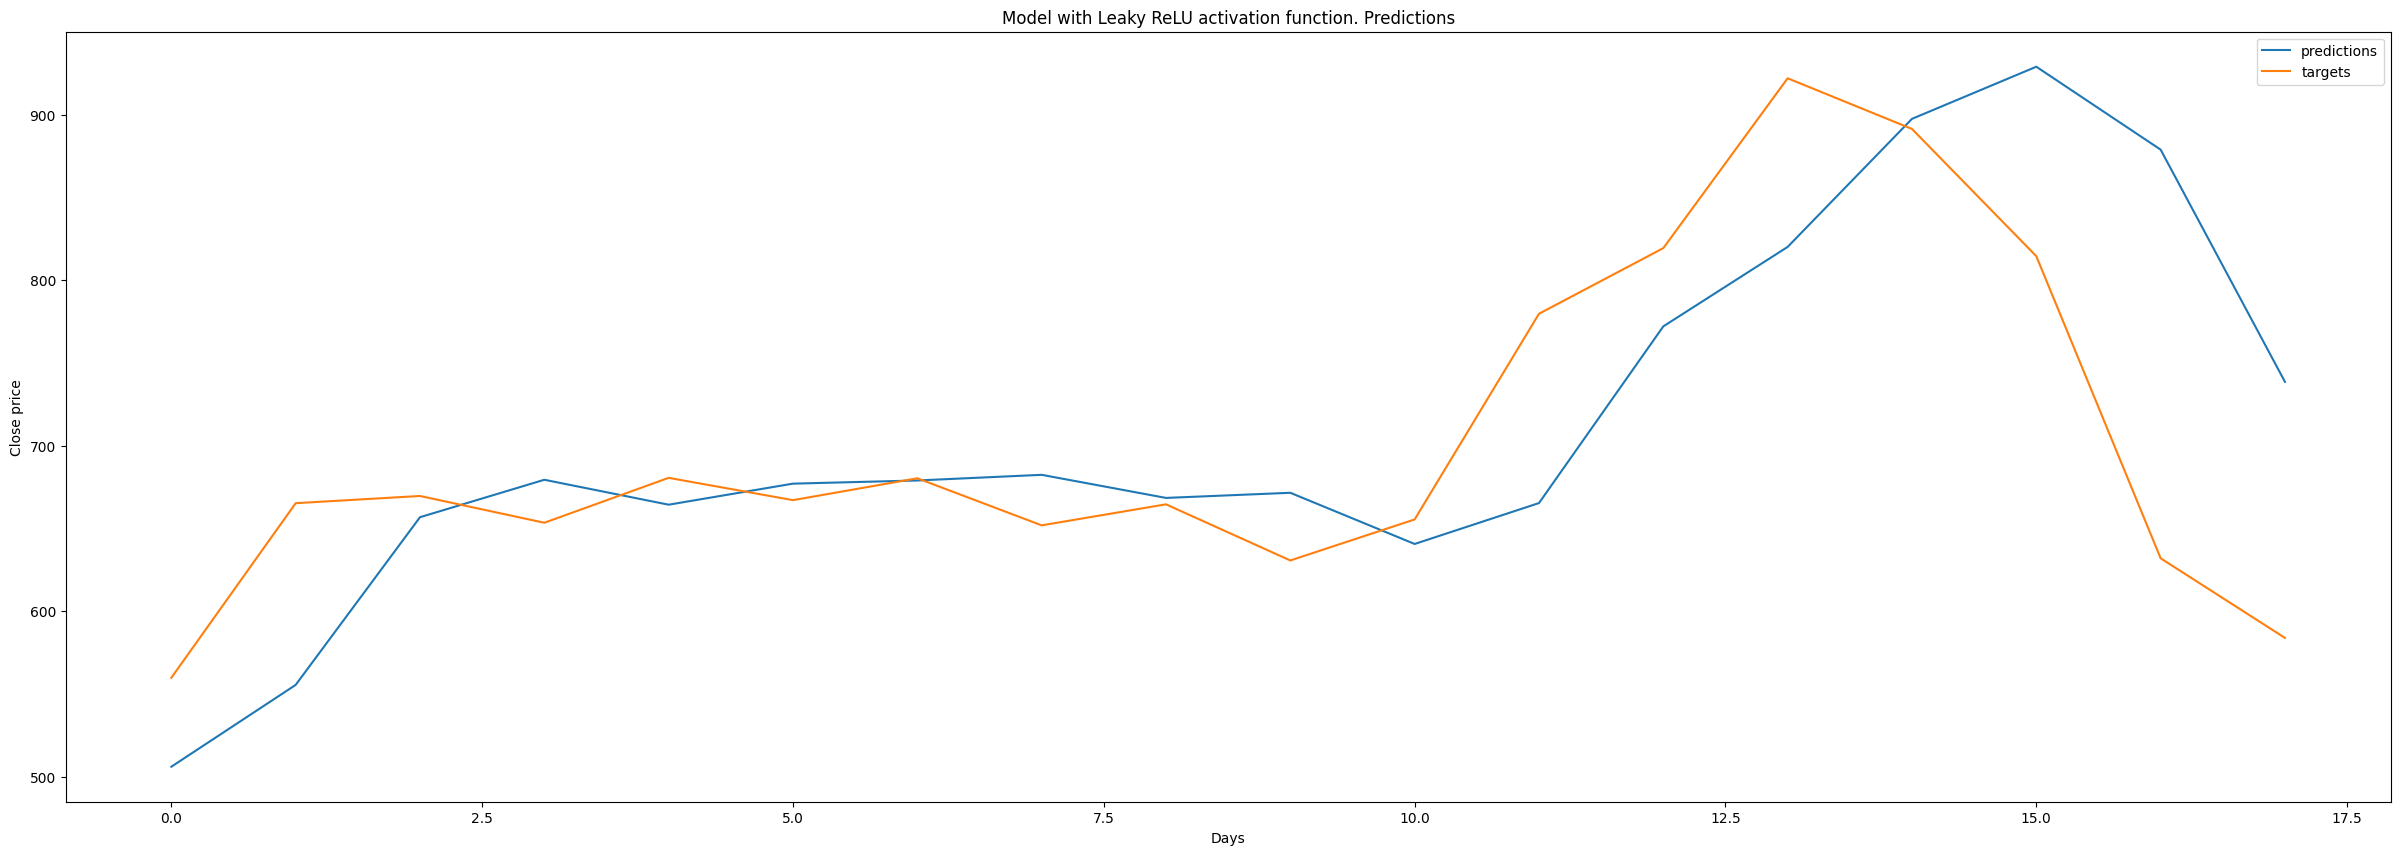

In [69]:
import matplotlib.pyplot as plt

from simple_rnn import SimpleRNN

# Load and prepare data
sequence_length = 2
train_sequences = create_sequences(train_data, sequence_length)

# Define activation functions to test
activation_functions: dict[str, Callable[[float], float]] = {
    "ReLU": relu,
    "Leaky ReLU": leaky_relu,
    "ELU": elu,
    "Tanh": tanh,
    "Sigmoid": sigmoid,
}
activation_functions = {
    "Leaky ReLU": leaky_relu,
}

for activation_function_name in activation_functions:
    activation_function = activation_functions[activation_function_name]
    # Initialize and train RNN
    rnn = SimpleRNN(
        input_size=train_data.shape[1],
        hidden_size=30,
        activation_function=activation_function,
    )
    train_rnn(rnn, train_sequences, epochs=20, learning_rate=0.001)
    # Test the RNN (no training)
    predictions, targets = test_rnn(rnn, test_data, normalisation_params, sequence_length)

    plt.figure(figsize = (30,10))
    plt.plot(predictions, label="predictions")
    plt.plot(targets, label="targets")
    plt.title(f"Model with {activation_function_name} activation function. Predictions")
    plt.xlabel("Days")
    plt.ylabel("Close price")

    plt.legend()
    plt.show()